Imports Required 

In [1]:
import os
import zipfile

import random
import math
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Flatten, Dense,\
                                    Dropout, BatchNormalization, Input
from tensorflow.keras.metrics import Mean, CosineSimilarity
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

Face_Data_Path is the dataset with all the faces 
Extracted_Faces_Path is the dataset where the face of the person is zoomed such that face is clearly visble without distractions

In [2]:
FACE_DATA_PATH = r"/Users/nikhil/Downloads/ML_MajorProject_Datasets/Face_Data/Face_Dataset"
EXTRACTED_FACES_PATH = r"/Users/nikhil/Downloads/ML_MajorProject_Datasets/Extracted_Faces/Extracted_Faces" 

Explore folder sees through the folder and organises it and gives the brief i.e the unique imagews and the total images and people

In [3]:
def explore_folder(folder_path):
    print(f'Exploring {os.path.basename(folder_path)}')
    image_shapes = []
    num_images = 0
    num_people = 0
    for folder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder_name)
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            image = cv2.imread(image_path)
            image_shapes.append(image.shape)
            num_images += 1
        num_people +=1
    print(f'Unique image shapes in: {set(image_shapes)}')
    print(f"Total number of images: {num_images}")
    print(f"Total number of people: {num_peopl# Import necessary modules})
import os
import cv2

def explore_folder(folder_path):
    # Print a message indicating the folder being explored
    print(f'Exploring {os.path.basename(folder_path)}')
    
    # Initialize empty lists and counters for image shapes and statistics
    image_shapes = []
    num_images = 0
    num_people = 0
    
    # Iterate over subfolders in the given folder
    for folder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder_name)
        
        # Iterate over images in each subfolder
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            
            # Read the image using OpenCV
            image = cv2.imread(image_path)
            
            # Append the image shape to the list
            image_shapes.append(image.shape)
            
            # Increment the counter for the total number of images
            num_images += 1
        
        # Increment the counter for the total number of people (subfolders)
        num_people += 1
    
    # Print unique image shapes, total number of images, and total number of people
    print(f'Unique image shapes in: {set(image_shapes)}')
    print(f"Total number of images: {num_images}")
    print(f"Total number of people: {num_people}")
    
    # Return the collected information
    return image_shapes, num_images, num_people
e}")
    return image_shapes, num_images, num_people

In [4]:
# Assuming FACE_DATA_PATH is defined earlier in the code, this line calls the explore_folder function with the specified path.
explore_folder(FACE_DATA_PATH)


Exploring Face_Dataset
Unique image shapes in: {(250, 250, 3)}
Total number of images: 8204
Total number of people: 1680


In [5]:
# Assuming EXTRACTED_FACES_PATH is defined earlier in the code, this line calls the explore_folder function with the specified path.
explore_folder(EXTRACTED_FACES_PATH)


Exploring Extracted_Faces
Unique image shapes in: {(128, 128, 3)}
Total number of images: 6107
Total number of people: 1324


visualize_sample_images helps us visualise the images of a person with their id on top

In [6]:
# Function to visualize sample images from a specified folder path
def visualize_sample_images(folder_path):
    # Count the number of images in the folder
    num_images = len(os.listdir(folder_path))

    # Calculate the number of rows and columns for the subplots grid
    num_rows = (num_images + 4) // 5
    num_cols = min(num_images, 5)

    # Create a subplot grid with specified dimensions
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

    # Iterate through each image in the folder
    for i, image_name in enumerate(os.listdir(folder_path)):
        # Read and convert the image to RGB format
        image_path = os.path.join(folder_path, image_name)
        sample_image = cv2.imread(image_path)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

        # Calculate the row and column index for the current image
        row = i // num_cols
        col = i % num_cols

        # Adjust the axes based on the grid layout
        if num_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]

        # Display the image on the current subplot
        ax.imshow(sample_image)
        ax.axis('off')

    # Remove empty subplots for any unused grid spaces
    for ax in axes.flat[num_images:]:
        ax.remove()

    # Set a title for the entire visualization based on the folder name
    plt.suptitle(f'Person ID: {os.path.basename(folder_path)}')

    # Adjust layout for better spacing and display the visualization
    plt.tight_layout()
    plt.show()


Samples from Face_Dataset


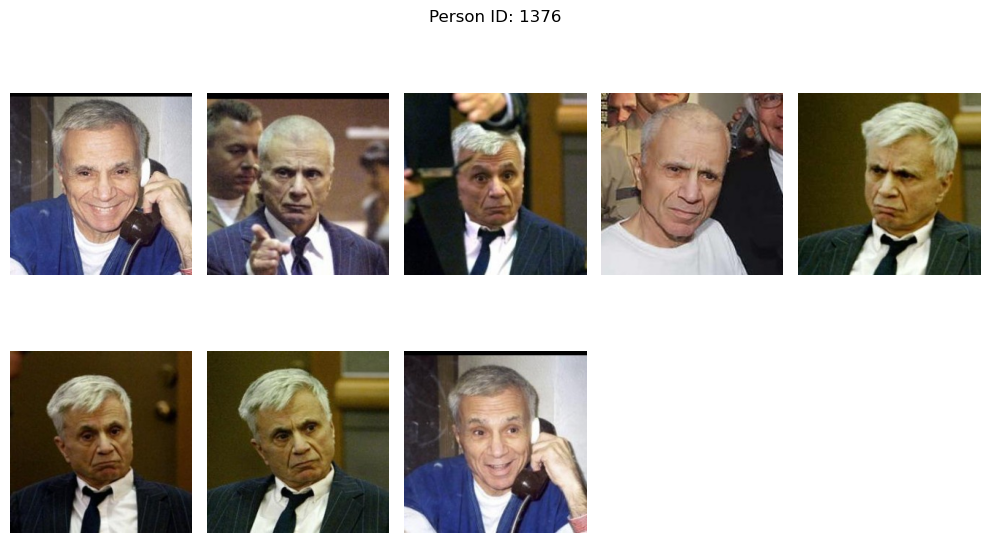

In [7]:
# Randomly select a person ID from the FACE_DATA_PATH
person_id = random.choice(os.listdir(FACE_DATA_PATH))

# Construct the full path to the selected person's folder
folder_path = os.path.join(FACE_DATA_PATH, person_id)

# Print a message indicating the source of the samples
print(f'Samples from {os.path.basename(FACE_DATA_PATH)}')

# Visualize sample images from the selected person's folder
visualize_sample_images(folder_path)


Samples from Extracted_Faces


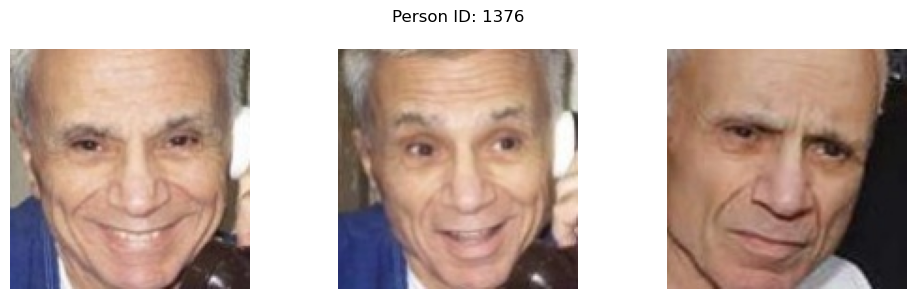

In [8]:
# Print a message indicating the source of the samples from EXTRACTED_FACES_PATH
print(f'Samples from {os.path.basename(EXTRACTED_FACES_PATH)}')

# Check if the selected person ID exists in EXTRACTED_FACES_PATH
if person_id in os.listdir(EXTRACTED_FACES_PATH):
    # If the person ID exists, construct the full path to the person's folder
    folder_path = os.path.join(EXTRACTED_FACES_PATH, person_id)

    # Visualize sample images from the selected person's folder
    visualize_sample_images(folder_path)
else:
    # If the person ID does not exist, print a message indicating so
    print(f'There is no person {person_id} in this folder')


copy_to_output_dataset this functions helps us to make a dataset using both face_data and extracted_face_data

In [9]:
# Define the path for the new dataset
DATASET = r"/Users/nikhil/Downloads/ML_MajorProject_Datasets/Dataset"

# Check if the dataset directory already exists, and if so, remove it
if os.path.exists(DATASET):
    shutil.rmtree(DATASET)

# Create the dataset directory
os.makedirs(DATASET)

# Function to copy images from input_path to output_path with unique names
def copy_to_output_dataset(input_path, output_path):
    # Iterate through each person's folder in the input_path
    for person_folder in os.listdir(input_path):
        person_folder_path = os.path.join(input_path, person_folder)
        
        # Check if the item is a directory
        if os.path.isdir(person_folder_path):
            # Create the corresponding person's folder in the output_path
            output_person_folder = os.path.join(output_path, person_folder)
            
            # If the person's folder doesn't exist in the output_path, create it
            if not os.path.exists(output_person_folder):
                os.makedirs(output_person_folder)

            # Iterate through each image file in the person's folder
            for image_file in os.listdir(person_folder_path):
                # Check if the file is a JPEG image
                if image_file.endswith('.jpg'):
                    src_image_path = os.path.join(person_folder_path, image_file)
                    dst_image_path = os.path.join(output_person_folder, image_file)
                    
                    # Check if a file with the same name already exists in the output_path
                    if os.path.exists(dst_image_path):
                        base, ext = os.path.splitext(dst_image_path)
                        dst_image_path = f"{base}_1{ext}"
                    
                    # Copy the image to the output_path with a unique name
                    shutil.copy(src_image_path, dst_image_path)

# Copy images from FACE_DATA_PATH to the new dataset
copy_to_output_dataset(FACE_DATA_PATH, DATASET)

# Copy images from EXTRACTED_FACES_PATH to the new dataset
copy_to_output_dataset(EXTRACTED_FACES_PATH, DATASET)


In [10]:
# Explore the contents of the created DATASET
explore_folder(DATASET)


Exploring Dataset
Unique image shapes in: {(250, 250, 3), (128, 128, 3)}
Total number of images: 14311
Total number of people: 1680


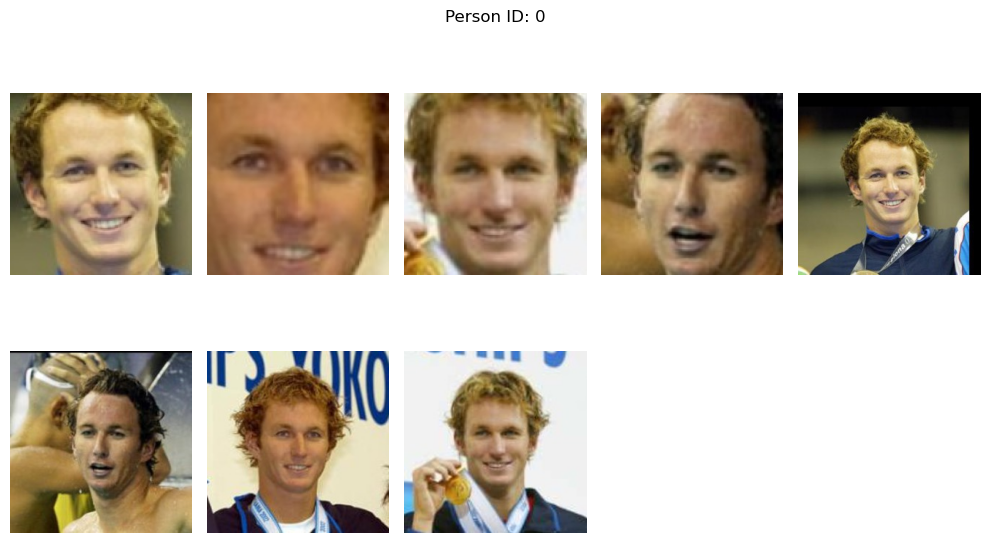

In [11]:
# Visualize sample images from the '0' subfolder within the DATASET
visualize_sample_images(os.path.join(DATASET, '0'))


In [12]:
# Function to generate triplets from given list of folder paths
def triplets(folder_paths, max_triplets=7):
    anchor_images = []
    positive_images = []
    negative_images = []

    # Iterate through each person's folder in the given list of folder paths
    for person_folder in folder_paths:
        # List all images in the current person's folder
        images = [os.path.join(person_folder, img) for img in os.listdir(person_folder)]
        num_images = len(images)

        # Skip if there are less than two images in the folder
        if num_images < 2:
            continue

        # Shuffle the list of images
        random.shuffle(images)

        # Generate triplets
        for _ in range(max(num_images - 1, max_triplets)):
            # Choose a random anchor image
            anchor_image = random.choice(images)

            # Choose a random positive image (different from the anchor image)
            positive_image = random.choice([x for x in images if x != anchor_image])

            # Choose a random negative folder (different from the person's folder)
            negative_folder = random.choice([x for x in folder_paths if x != person_folder])

            # Choose a random negative image from the selected negative folder
            negative_image = random.choice([os.path.join(negative_folder, img) for img in os.listdir(negative_folder)])

            # Append the chosen images to their respective lists
            anchor_images.append(anchor_image)
            positive_images.append(positive_image)
            negative_images.append(negative_image)

    # Return the generated triplets
    return anchor_images, positive_images, negative_images


In [13]:
# Create a list of full paths to each person's folder in the DATASET
person_folders = [os.path.join(DATASET, folder_name) for folder_name in os.listdir(DATASET)]

# Generate triplets using the provided function
anchors, positives, negatives = triplets(person_folders)


In [14]:
# Function to split triplets into training and validation sets
def split_triplets(anchors, positives, negatives, validation_split=0.2):
    # Combine anchors, positives, and negatives into a list of triplets
    triplets = list(zip(anchors, positives, negatives))

    # Split triplets into training and validation sets
    train_triplets, val_triplets = train_test_split(triplets,
                                                    test_size=validation_split,
                                                    random_state=42)

    # Return the training and validation triplets
    return train_triplets, val_triplets


In [15]:
# Split the generated triplets into training and validation sets
train_triplets, val_triplets = split_triplets(anchors, positives, negatives)

# Print the number of triplets in the training and validation sets
print(f"Number of triplets in the training set: {len(train_triplets)}")
print(f"Number of triplets in the validation set: {len(val_triplets)}")


(13854, 3464)

In [16]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path, expand_dims=False):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Convert the image to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image to (128, 128)
    image = cv2.resize(image, (128, 128))
    
    # Optionally expand dimensions if specified
    if expand_dims:
        image = np.expand_dims(image, axis=0)
    
    return image


In [17]:
# Generator function to yield batches of triplets for training
def batch_generator(triplets, batch_size=32, augment=True):
    total_triplets = len(triplets)
    random_indices = list(range(total_triplets))
    random.shuffle(random_indices)
    
    # Image data augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=10,  
        width_shift_range=0.05, 
        height_shift_range=0.05,   
        horizontal_flip=True,
        zoom_range=0.2
    )
    
    # Generate batches of triplets
    for i in range(0, total_triplets, batch_size):
        batch_indices = random_indices[i:i + batch_size]
        batch_triplets = [triplets[j] for j in batch_indices]

        anchor_batch = []
        positive_batch = []
        negative_batch = []

        # Load and preprocess images for each triplet in the batch
        for triplet in batch_triplets:
            anchor, positive, negative = triplet
            
            anchor_image = load_and_preprocess_image(anchor)
            positive_image = load_and_preprocess_image(positive)
            negative_image = load_and_preprocess_image(negative)
                
            # Apply data augmentation if specified
            if augment:
                anchor_image = datagen.random_transform(anchor_image)
                positive_image = datagen.random_transform(positive_image)
                negative_image = datagen.random_transform(negative_image)

            anchor_batch.append(anchor_image)
            positive_batch.append(positive_image)
            negative_batch.append(negative_image)

        # Yield the batch of triplets
        yield [np.array(anchor_batch),
               np.array(positive_batch),
               np.array(negative_batch)]



In [18]:
# Function to visualize batches of triplets
def visualize_triplets(triplets):
    anchor_batch, positive_batch, negative_batch = triplets

    # Iterate through each triplet in the batch
    for i in range(len(anchor_batch)):
        plt.figure(figsize=(15, 5))

        # Display the anchor image
        plt.subplot(1, 3, 1)
        plt.title("Anchor")
        plt.imshow(anchor_batch[i])
        plt.axis('off')

        # Display the positive image
        plt.subplot(1, 3, 2)
        plt.title("Positive")
        plt.imshow(positive_batch[i])
        plt.axis('off')

        # Display the negative image
        plt.subplot(1, 3, 3)
        plt.title("Negative")
        plt.imshow(negative_batch[i])
        plt.axis('off')

        # Show the visualization for the current triplet
        plt.show()


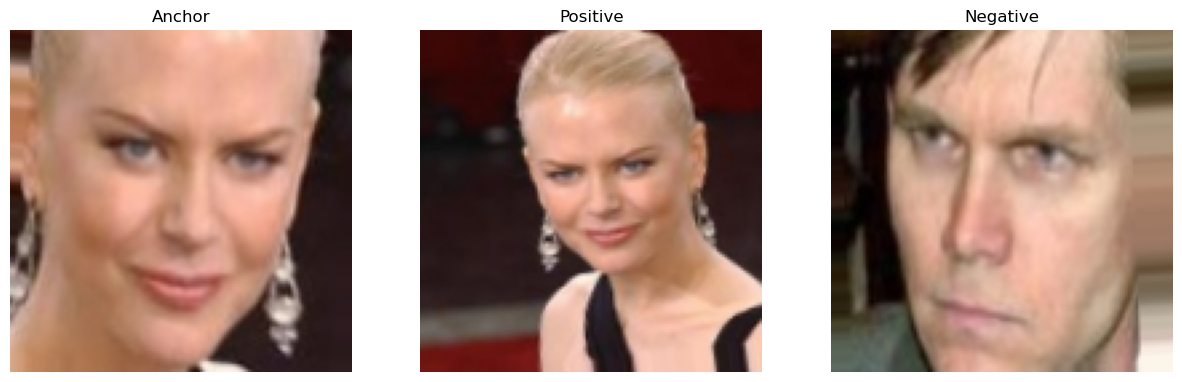

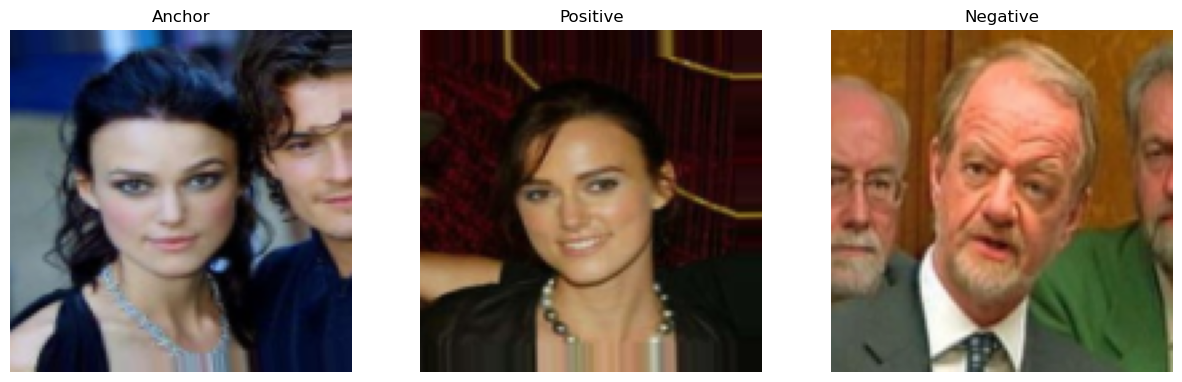

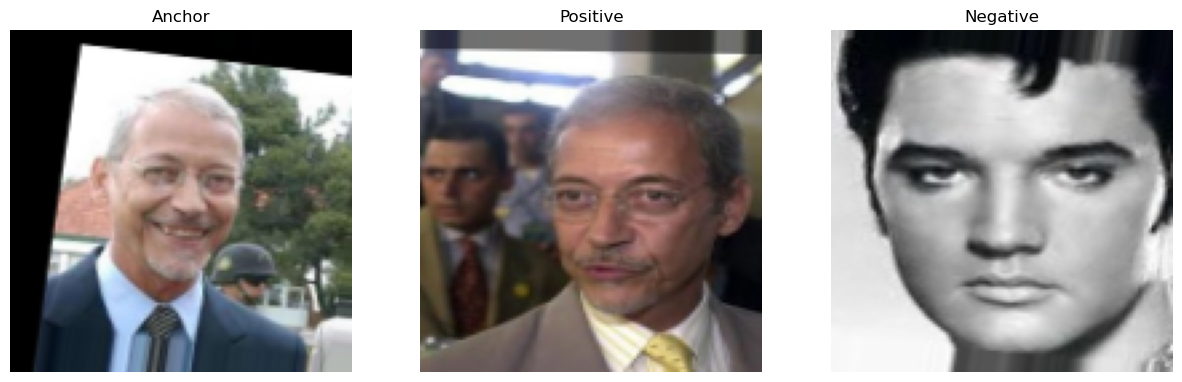

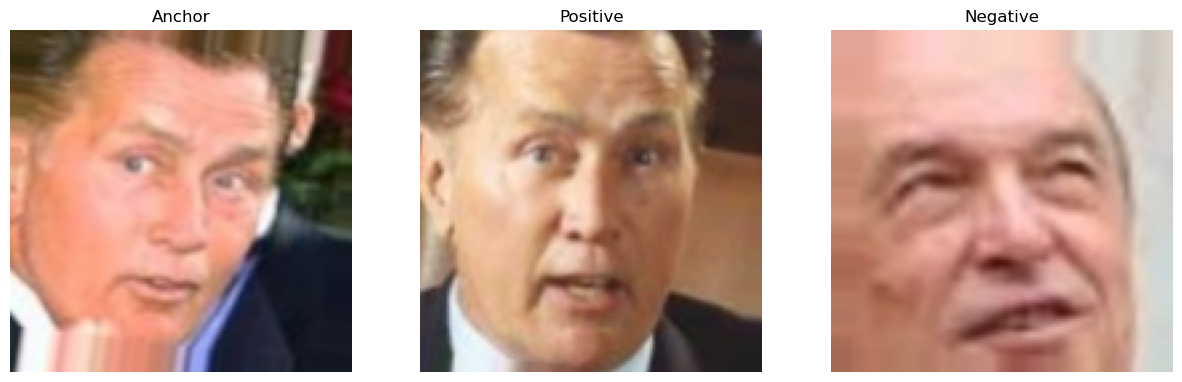

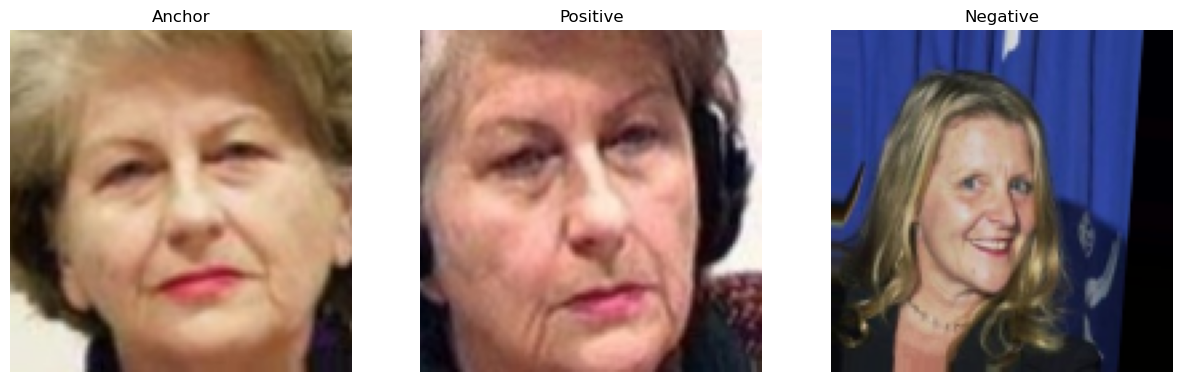

In [19]:
# Generate an example batch of triplets and visualize them
example_triplets = [next(batch_generator(train_triplets, 5))]
visualize_triplets(example_triplets[0])


In [20]:
# Function to create an embedding model
def get_embedding(input_shape, num_layers_to_unfreeze=25):
    # Load the EfficientNetB7 model with pre-trained weights
    base_model = EfficientNetB7(weights='imagenet',
                                input_shape=input_shape,
                                include_top=False,
                                pooling='avg')

    # Freeze layers up to the specified number
    for i in range(len(base_model.layers) - num_layers_to_unfreeze):
        base_model.layers[i].trainable = False

    # Build the embedding model
    embedding = tf.keras.models.Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(128)
    ], name='Embedding')

    return embedding


In [21]:
# Define the input shape for the embedding model
input_shape = (128, 128, 3)

# Create an embedding model
embedding = get_embedding(input_shape)

# Display the summary of the embedding model
embedding.summary()


Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               13

In [22]:
# Custom layer to compute distances between anchor, positive, and negative embeddings
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

# Define input layers for anchor, positive, and negative images
anchor_input = Input(name='anchor', shape=input_shape)
positive_input = Input(name='positive', shape=input_shape)
negative_input = Input(name='negative', shape=input_shape)

# Compute embeddings for anchor, positive, and negative images using the embedding model
distances = DistanceLayer()(
    embedding(load_and_preprocess_image(anchor_input)),
    embedding(load_and_preprocess_image(positive_input)),
    embedding(load_and_preprocess_image(negative_input))
)

# Create a Siamese network model
siamese_net = Model(
    inputs=[anchor_input,
            positive_input,
            negative_input],
    outputs=distances
)


In [23]:
# Display the summary of the Siamese network model
siamese_net.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 positive (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 negative (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Embedding (Sequential)      (None, 128)                  6559323   ['anchor[0][0]',              
                                                          9          'positive[0][0]',        

In [24]:
# Custom SiameseModel class definition
class SiameseModel(Model):
    def __init__(self, siamese_net, margin=0.5):
        super().__init__()
        self.siamese_net = siamese_net
        self.margin = margin
        self.loss_tracker = Mean(name='loss')
        self.accuracy_tracker = Mean(name='accuracy')

    def call(self, inputs):
        return self.siamese_net(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_net.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_net.trainable_weights)
        )

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_net(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, .0)
        return loss

    def _compute_accuracy(self, data):
        ap_distance, an_distance = self.siamese_net(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance,
                                          tf.float32))
        return accuracy

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def get_config(self):
        base_config = super().get_config()
        config = {
            'siamese_net': tf.keras.saving.serialize_keras_object(self.siamese_net),
            'margin': self.margin,
            'loss_tracker': tf.keras.saving.serialize_keras_object(self.loss_tracker),
            'accuracy_tracker': tf.keras.saving.serialize_keras_object(self.accuracy_tracker),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        config['siamese_net'] = tf.keras.saving.deserialize_keras_object(config.pop('siamese_net'))
        config['margin'] = config.pop('margin')
        config['loss_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('loss_tracker'))
        config['accuracy_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('accuracy_tracker'))
        return cls(**config)


In [25]:
# Function to train the Siamese model
def train_model(model, train_triplets, epochs, batch_size, val_triplets, patience, delta=0.0001):
    best_val_accuracy = 0
    best_val_loss = float('inf')
    temp_patience = patience
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    train_steps_per_epoch = math.ceil(len(train_triplets) / batch_size)
    val_steps_per_epoch = math.ceil(len(val_triplets) / batch_size)

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss = 0.
        train_accuracy = 0.
        val_loss = 0.
        val_accuracy = 0.

        with tqdm(total=train_steps_per_epoch, desc='Training') as pbar:
            for batch in batch_generator(train_triplets, batch_size=batch_size):
                loss, accuracy = model.train_on_batch(batch)
                train_loss += loss
                train_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        with tqdm(total=val_steps_per_epoch, desc='Validation') as pbar:
            for batch in batch_generator(val_triplets, batch_size=batch_size):
                loss, accuracy = model.test_on_batch(batch)
                val_loss += loss
                val_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        train_loss /= train_steps_per_epoch
        train_accuracy /= train_steps_per_epoch
        val_loss /= val_steps_per_epoch
        val_accuracy /= val_steps_per_epoch

        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model.layers[0].layers[3].save_weights('best_model.weights.h5')

        if val_loss - best_val_loss > delta:
            temp_patience -= 1
            if temp_patience == 0:
                print('Early stopping: Validation loss did not improve.')
                break
        else:
            best_val_loss = val_loss
            temp_patience = patience

    return model, history


In [26]:
siamese_model = SiameseModel(siamese_net)
siamese_model.compile(optimizer=Adam(0.001))

siamese_model, history = train_model(siamese_model,
                                     train_triplets=train_triplets,
                                     epochs=200,
                                     batch_size=32,
                                     val_triplets=val_triplets,
                                     patience=3)

Epoch 1/200


Training: 100%|███| 433/433 [38:30<00:00,  5.34s/it, Loss=0.265, Accuracy=0.867]
Validation: 100%|█| 109/109 [06:07<00:00,  3.37s/it, Loss=0.0895, Accuracy=0.875



Train Loss: 0.2696, Train Accuracy: 0.8666
Validation Loss: 0.2295, Validation Accuracy: 0.8125

Epoch 2/200


Validation: 100%|█| 109/109 [05:50<00:00,  3.21s/it, Loss=0.406, Accuracy=0.625]



Train Loss: 0.2291, Train Accuracy: 0.8784
Validation Loss: 0.2217, Validation Accuracy: 0.8274

Epoch 3/200


Validation: 100%|█████████| 109/109 [05:52<00:00,  3.23s/it, Loss=0, Accuracy=1]



Train Loss: 0.1938, Train Accuracy: 0.8806
Validation Loss: 0.1983, Validation Accuracy: 0.8277

Epoch 4/200


Validation: 100%|█| 109/109 [05:50<00:00,  3.21s/it, Loss=0.462, Accuracy=0.625]



Train Loss: 0.1814, Train Accuracy: 0.8896
Validation Loss: 0.2047, Validation Accuracy: 0.8417

Epoch 5/200


Validation: 100%|█████| 109/109 [06:04<00:00,  3.35s/it, Loss=0.154, Accuracy=1]



Train Loss: 0.1843, Train Accuracy: 0.9007
Validation Loss: 0.1973, Validation Accuracy: 0.8380

Epoch 6/200


Validation: 100%|█| 109/109 [05:49<00:00,  3.20s/it, Loss=0.404, Accuracy=0.625]



Train Loss: 0.1645, Train Accuracy: 0.9002
Validation Loss: 0.1786, Validation Accuracy: 0.8592

Epoch 7/200


Training: 100%|█████| 433/433 [25:27<00:00,  3.53s/it, Loss=0.124, Accuracy=0.9]
Validation: 100%|█| 109/109 [05:47<00:00,  3.19s/it, Loss=0.0848, Accuracy=0.875



Train Loss: 0.1478, Train Accuracy: 0.9044
Validation Loss: 0.1712, Validation Accuracy: 0.8610

Epoch 8/200


Validation: 100%|█| 109/109 [06:08<00:00,  3.38s/it, Loss=0.319, Accuracy=0.875]



Train Loss: 0.1352, Train Accuracy: 0.9138
Validation Loss: 0.1628, Validation Accuracy: 0.8727

Epoch 9/200


Validation: 100%|██| 109/109 [05:45<00:00,  3.17s/it, Loss=0.244, Accuracy=0.75]



Train Loss: 0.1304, Train Accuracy: 0.9201
Validation Loss: 0.1670, Validation Accuracy: 0.8658

Epoch 10/200


Validation: 100%|█████████| 109/109 [05:53<00:00,  3.24s/it, Loss=0, Accuracy=1]



Train Loss: 0.1232, Train Accuracy: 0.9225
Validation Loss: 0.1792, Validation Accuracy: 0.8618

Epoch 11/200


Validation: 100%|██| 109/109 [05:58<00:00,  3.29s/it, Loss=0.275, Accuracy=0.75]


Train Loss: 0.1523, Train Accuracy: 0.9124
Validation Loss: 0.1866, Validation Accuracy: 0.8546

Early stopping: Validation loss did not improve.


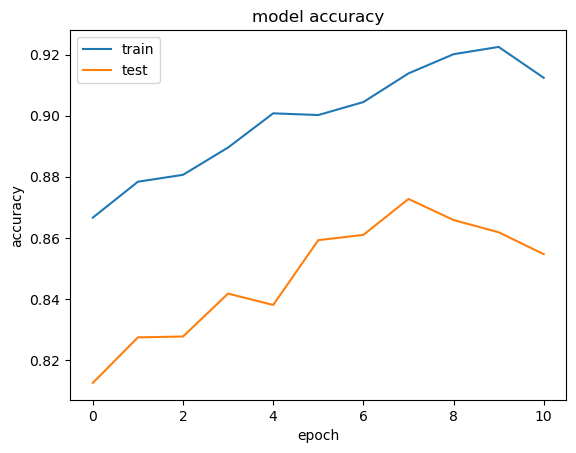

In [27]:
# Plot training and validation accuracy
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


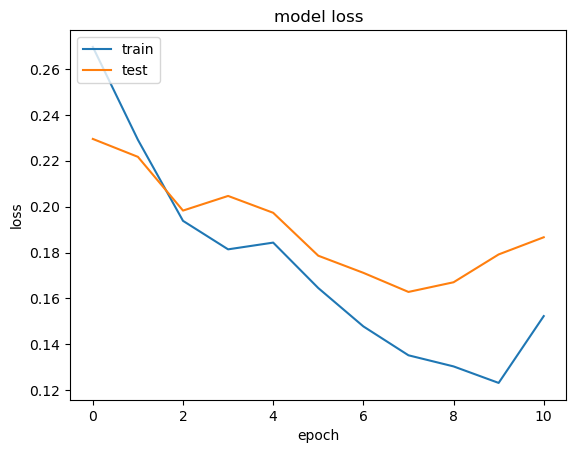

In [28]:
# Plot training and validation loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


quadraplets function is used to make quadraplets where in each quadraplets has one anchor image , two positive image and one negative image.

In [12]:
# Function to generate quadruplets for Siamese network training
def quadraplets(folder_paths, max_quadraplets=7):
    # Lists to store file paths for anchor, positive1, positive2, and negative images
    anchor_images = []
    positive_images1 = []
    positive_images2 = []
    negative_images = []

    # Iterate over each person's folder
    for person_folder in folder_paths:
        # Create a list of file paths for images in the person's folder
        images = [os.path.join(person_folder, img) for img in os.listdir(person_folder)]
        num_images = len(images)

        # Skip if there are fewer than 2 images in the folder
        if num_images < 2:
            continue

        # Shuffle the list of images
        random.shuffle(images)

        # Generate quadruplets for the current person
        for _ in range(max(num_images - 1, max_quadraplets)):
            # Randomly choose an anchor image
            anchor_image = random.choice(images)

            # Randomly choose two positive images (different from the anchor image)
            positive_image1 = random.choice([x for x in images if x != anchor_image])
            positive_image2 = random.choice([x for x in images if x != anchor_image])

            # Randomly choose a negative folder (different from the current person's folder)
            negative_folder = random.choice([x for x in folder_paths if x != person_folder])

            # Randomly choose a negative image from the negative folder
            negative_image = random.choice([os.path.join(negative_folder, img) for img in os.listdir(negative_folder)])

            # Append file paths to the respective lists
            anchor_images.append(anchor_image)
            positive_images1.append(positive_image1)
            positive_images2.append(positive_image2)
            negative_images.append(negative_image)

    # Return the generated quadruplets
    return anchor_images, positive_images1, positive_images2, negative_images


Person_Folder has all the quadraplets

In [13]:
person_folders = [os.path.join(DATASET, folder_name)
                  for folder_name in os.listdir(DATASET)]

anchors, positives1, positives2, negatives = quadraplets(person_folders)

We split into train and validation

In [14]:
# Function to split quadruplets into training and validation sets
def split_quadraplets(anchors, positives1, positives2, negatives, validation_split=0.2):
    # Combine the lists of anchors, positives1, positives2, and negatives into quadruplets
    quadraplets = list(zip(anchors, positives1, positives2, negatives))

    # Split the quadruplets into training and validation sets
    train_quadraplets, val_quadraplets = train_test_split(quadraplets,
                                                          test_size=validation_split,
                                                          random_state=42)

    # Return the training and validation quadruplets
    return train_quadraplets, val_quadraplets


In [15]:
# Split quadruplets into training and validation sets
train_quadraplets, val_quadraplets = split_quadraplets(anchors, positives1, positives2, negatives)

# Display the number of quadruplets in the training and validation sets
len(train_quadraplets), len(val_quadraplets)


(13854, 3464)

Preprocessing the images

In [16]:
# Function to load and preprocess an image from a given file path
def load_and_preprocess_image(image_path, expand_dims=False):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Convert the image to RGB color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image to (128, 128)
    image = cv2.resize(image, (128, 128))
    
    # Optionally expand dimensions if needed
    if expand_dims:
        image = np.expand_dims(image, axis=0)
    
    # Return the preprocessed image
    return image


In [17]:
# Function to generate batches of quadruplets for training
def batch_generator(quadraplets, batch_size=32, augment=True):
    # Get the total number of quadruplets
    total_quadraplets = len(quadraplets)
    
    # Create a list of random indices for shuffling
    random_indices = list(range(total_quadraplets))
    random.shuffle(random_indices)
    
    # Create an image data generator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,  
        width_shift_range=0.05, 
        height_shift_range=0.05,   
        horizontal_flip=True,
        zoom_range=0.2
    )
    
    # Generate batches of quadruplets
    for i in range(0, total_quadraplets, batch_size):
        batch_indices = random_indices[i:i + batch_size]
        batch_quadraplets = [quadraplets[j] for j in batch_indices]

        anchor_batch = []
        positive_batch1 = []
        positive_batch2 = []
        negative_batch = []

        # Process each quadruplet in the batch
        for triplet in batch_quadraplets:
            anchor, positive1, positive2, negative = triplet
            
            # Load and preprocess images
            anchor_image = load_and_preprocess_image(anchor)
            positive_image1 = load_and_preprocess_image(positive1)
            positive_image2 = load_and_preprocess_image(positive2)
            negative_image = load_and_preprocess_image(negative)
                
            # Augment images if specified
            if augment:
                anchor_image = datagen.random_transform(anchor_image)
                positive_image1 = datagen.random_transform(positive_image1)
                positive_image2 = datagen.random_transform(positive_image2)
                negative_image = datagen.random_transform(negative_image)

            # Append images to the respective batches
            anchor_batch.append(anchor_image)
            positive_batch1.append(positive_image1)
            positive_batch2.append(positive_image2)
            negative_batch.append(negative_image)

        # Yield the batches as a list
        yield [np.array(anchor_batch),
               np.array(positive_batch1),
               np.array(positive_batch2),
               np.array(negative_batch)]


In [46]:
# Function to visualize batches of quadruplets
def visualize_quadraplets(quadraplets):
    # Unpack quadruplet batches
    anchor_batch, positive_batch1, positive_batch2, negative_batch = quadraplets

    # Iterate through each quadruplet in the batch
    for i in range(len(anchor_batch)):
        plt.figure(figsize=(15, 5))

        # Display anchor image
        plt.subplot(1, 4, 1)
        plt.title("Anchor")
        plt.imshow(anchor_batch[i])
        plt.axis('off')

        # Display positive1 image
        plt.subplot(1, 4, 2)
        plt.title("Positive1")
        plt.imshow(positive_batch1[i])
        plt.axis('off')

        # Display positive2 image
        plt.subplot(1, 4, 3)
        plt.title("Positive2")
        plt.imshow(positive_batch2[i])
        plt.axis('off')

        # Display negative image
        plt.subplot(1, 4, 4)
        plt.title("Negative")
        plt.imshow(negative_batch[i])
        plt.axis('off')

        # Show the plot for the current quadruplet
        plt.show()


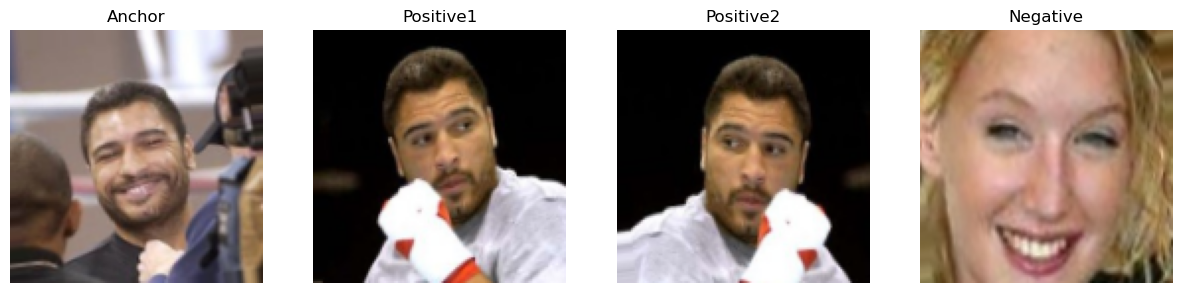

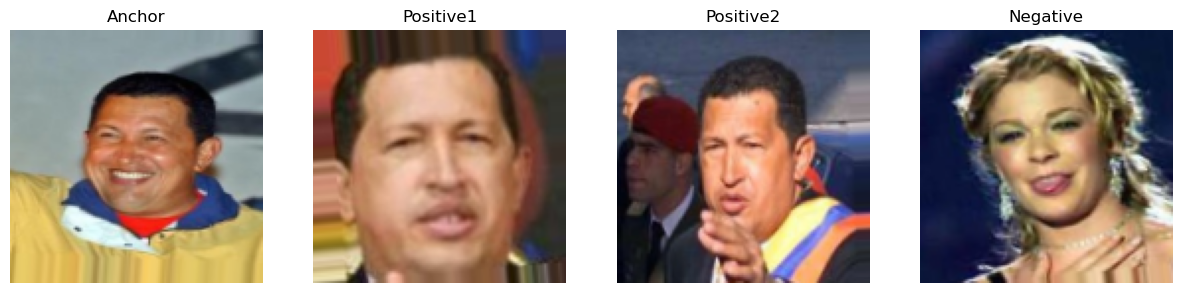

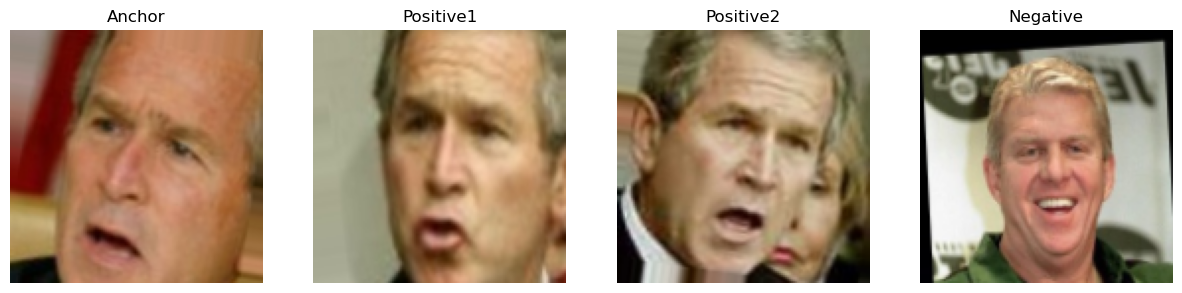

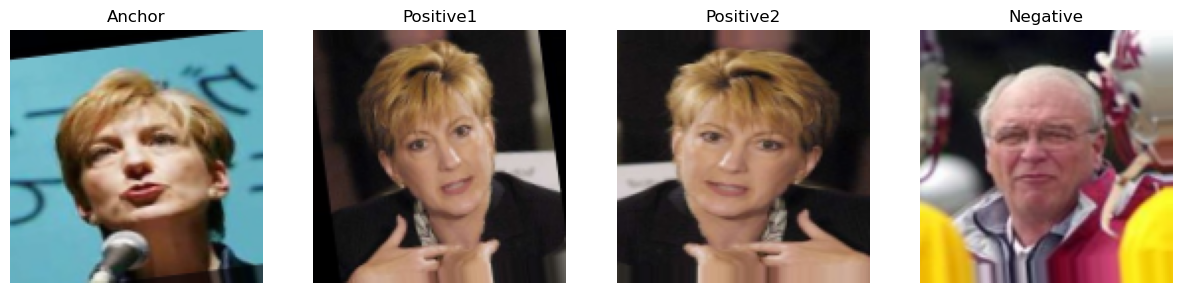

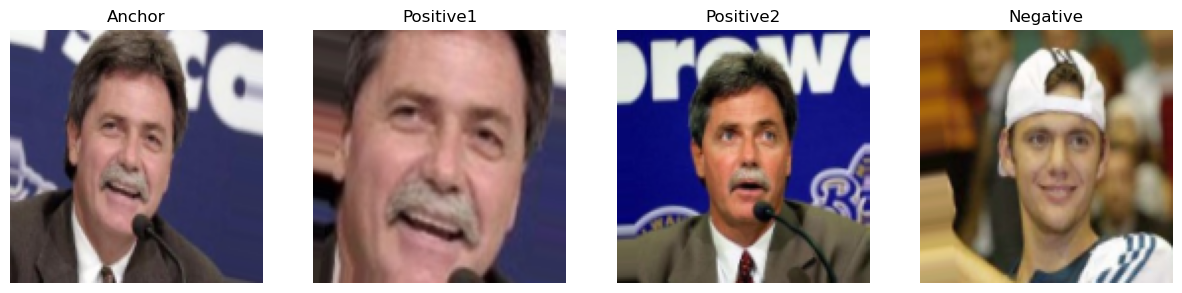

In [47]:
# Generate an example batch of quadruplets and visualize them
example_quadraplets = [next(batch_generator(train_quadraplets, 5))]
visualize_quadraplets(example_quadraplets[0])


We use the get_embedding function to embed out image into a array form 

In [18]:
# Function to create a Siamese network embedding model
def get_embedding(input_shape, num_layers_to_unfreeze=25):
    # Load the pre-trained EfficientNetB7 model
    base_model = EfficientNetB7(weights='imagenet',
                                input_shape=input_shape,
                                include_top=False,
                                pooling='avg')

    # Freeze the specified number of layers
    for i in range(len(base_model.layers) - num_layers_to_unfreeze):
        base_model.layers[i].trainable = False

    # Create a Sequential model for embedding
    embedding = tf.keras.models.Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(128)
    ], name='Embedding')

    # Return the embedding model
    return embedding


In [19]:
# Define the input shape for the embedding model
input_shape = (128, 128, 3)

# Create the embedding model
embedding = get_embedding(input_shape)

# Display the summary of the embedding model
embedding.summary()


Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               13

We use DistanceLayer to find the distance between the images

In [23]:
# Custom distance layer for computing triplet loss
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive1, positive2, negative):
        # Compute distances between anchor and positive images
        ap_distance1 = tf.reduce_sum(tf.square(anchor - positive1), -1)
        ap_distance2 = tf.reduce_sum(tf.square(anchor - positive2), -1)

        # Compute distance between anchor and negative images
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)

        # Combine distances for positive images
        ap_distance = ap_distance1 + ap_distance2 / 2

        return ap_distance, an_distance

# Define input layers for anchor, positive1, positive2, and negative images
anchor_input = Input(name='anchor', shape=input_shape)
positive_input1 = Input(name='positive1', shape=input_shape)
positive_input2 = Input(name='positive2', shape=input_shape)
negative_input = Input(name='negative', shape=input_shape)

# Compute distances using the embedding model and the DistanceLayer
distances = DistanceLayer()(
    embedding(preprocess_input(anchor_input)),
    embedding(preprocess_input(positive_input1)),
    embedding(preprocess_input(positive_input2)),
    embedding(preprocess_input(negative_input))
)

# Create the Siamese network model
siamese_net = Model(
    inputs=[anchor_input, positive_input1, positive_input2, negative_input],
    outputs=distances
)



In [24]:
# Display the summary of the Siamese network model
siamese_net.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 positive1 (InputLayer)      [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 positive2 (InputLayer)      [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 negative (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                              

IN SiameseModel we define various functions such as loss, accuracy ... 
and we use loss function as : ap_distance - an_distance where ap is the distsace between positive image and an is the distance between negative image and our goal is to minimise it the most 

In [25]:
# Siamese model class for training and testing
class SiameseModel(Model):
    def __init__(self, siamese_net, margin=0.5):
        super().__init__()
        self.siamese_net = siamese_net
        self.margin = margin
        self.loss_tracker = Mean(name='loss')
        self.accuracy_tracker = Mean(name='accuracy')

    def call(self, inputs):
        return self.siamese_net(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_net.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_net.trainable_weights)
        )

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_net(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, .0)
        return loss

    def _compute_accuracy(self, data):
        ap_distance, an_distance = self.siamese_net(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance,
                                          tf.float32))
        return accuracy

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def get_config(self):
        base_config = super().get_config()
        config = {
            'siamese_net': tf.keras.saving.serialize_keras_object(self.siamese_net),
            'margin': tf.keras.saving.serialize_keras_object(self.margin),
            'loss_tracker': tf.keras.saving.serialize_keras_object(self.loss_tracker),
            'accuracy_tracker': tf.keras.saving.serialize_keras_object(self.accuracy_tracker),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        config['siamese_net'] = tf.keras.saving.deserialize_keras_object(config.pop('siamese_net'))
        config['margin'] = tf.keras.saving.deserialize_keras_object(config.pop('margin'))
        config['loss_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('loss_tracker'))
        config['accuracy_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('accuracy_tracker'))
        return cls(**config)


We train the model using train_model 

In [26]:
def train_model(model,
                train_quadraplets,
                epochs,
                batch_size,
                val_quadraplets,
                patience,
                delta=0.0001):
    """
    Train a neural network model using the provided training and validation data.

    Parameters:
    - model (object): The neural network model to be trained.
    - train_quadraplets (list): List of training quadruplets (input data and corresponding labels).
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size used during training.
    - val_quadraplets (list): List of validation quadruplets for evaluating the model.
    - patience (int): Number of epochs with no improvement after which training will be stopped.
    - delta (float): Minimum change in the monitored quantity to qualify as an improvement.

    Returns:
    - model (object): Trained model.
    - history (dict): Training history containing loss and accuracy values for each epoch.
    """

    best_val_accuracy = 0
    best_val_loss = float('inf')
    temp_patience = patience
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    # Calculate the number of steps per epoch for training and validation
    train_steps_per_epoch = math.ceil(len(train_quadraplets) / batch_size)
    val_steps_per_epoch = math.ceil(len(val_quadraplets) / batch_size)

    # Training loop
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss = 0.
        train_accuracy = 0.
        val_loss = 0.
        val_accuracy = 0.

        # Training
        with tqdm(total=train_steps_per_epoch, desc='Training') as pbar:
            for batch in batch_generator(train_quadraplets, batch_size=batch_size):
                loss, accuracy = model.train_on_batch(batch)
                train_loss += loss
                train_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        # Validation
        with tqdm(total=val_steps_per_epoch, desc='Validation') as pbar:
            for batch in batch_generator(val_quadraplets, batch_size=batch_size):
                loss, accuracy = model.test_on_batch(batch)
                val_loss += loss
                val_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        # Average loss and accuracy over all batches
        train_loss /= train_steps_per_epoch
        train_accuracy /= train_steps_per_epoch
        val_loss /= val_steps_per_epoch
        val_accuracy /= val_steps_per_epoch

        # Save training history
        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        # Display training and validation metrics for the current epoch
        print(f'\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')

        # Save the model with the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model.layers[0].layers[4].save_weights('best_model.weights.h5')

        # Check for early stopping based on validation loss
        if val_loss - best_val_loss > delta:
            temp_patience -= 1
            if temp_patience == 0:
                print('Early stopping: Validation loss did not improve.')
                break
        else:
            best_val_loss = val_loss
            temp_patience = patience

    return model, history


In [27]:
# Create a Siamese model instance using the provided base Siamese network architecture.
siamese_model = SiameseModel(siamese_net)

# Compile the Siamese model using the Adam optimizer with a learning rate of 0.001.
siamese_model.compile(optimizer=Adam(0.001))

# Train the Siamese model using the custom training function.
# The training is performed for 200 epochs with a batch size of 32.
# Validation is conducted on the provided validation quadruplets.
# Early stopping is applied with a patience of 3 epochs.
siamese_model, history = train_model(siamese_model,
                                     train_quadraplets=train_quadraplets,
                                     epochs=200,
                                     batch_size=32,
                                     val_quadraplets=val_quadraplets,
                                     patience=3)


Epoch 1/200


Validation: 100%|███| 109/109 [07:56<00:00,  4.37s/it, Loss=0.355, Accuracy=0.5]



Train Loss: 0.3313, Train Accuracy: 0.7627
Validation Loss: 0.3377, Validation Accuracy: 0.7001

Epoch 2/200


Validation: 100%|█| 109/109 [07:33<00:00,  4.16s/it, Loss=0.105, Accuracy=0.875]



Train Loss: 0.2919, Train Accuracy: 0.7770
Validation Loss: 0.2811, Validation Accuracy: 0.7494

Epoch 3/200


Validation: 100%|██| 109/109 [07:35<00:00,  4.18s/it, Loss=0.203, Accuracy=0.75]



Train Loss: 0.2641, Train Accuracy: 0.7936
Validation Loss: 0.2877, Validation Accuracy: 0.7417

Epoch 4/200


Validation: 100%|██| 109/109 [07:36<00:00,  4.18s/it, Loss=0.305, Accuracy=0.75]



Train Loss: 0.2588, Train Accuracy: 0.8055
Validation Loss: 0.2808, Validation Accuracy: 0.7509

Epoch 5/200


Validation: 100%|█████| 109/109 [07:29<00:00,  4.13s/it, Loss=0.114, Accuracy=1]



Train Loss: 0.2581, Train Accuracy: 0.8032
Validation Loss: 0.2517, Validation Accuracy: 0.7784

Epoch 6/200


Validation: 100%|██| 109/109 [07:30<00:00,  4.13s/it, Loss=0.645, Accuracy=0.25]



Train Loss: 0.2310, Train Accuracy: 0.8134
Validation Loss: 0.2510, Validation Accuracy: 0.7729

Epoch 7/200


Validation: 100%|█| 109/109 [07:31<00:00,  4.14s/it, Loss=0.269, Accuracy=0.875]



Train Loss: 0.3543, Train Accuracy: 0.8126
Validation Loss: 0.2842, Validation Accuracy: 0.7563

Epoch 8/200


Validation: 100%|██| 109/109 [07:32<00:00,  4.15s/it, Loss=0.225, Accuracy=0.75]



Train Loss: 0.2241, Train Accuracy: 0.8208
Validation Loss: 0.2492, Validation Accuracy: 0.7841

Epoch 9/200


Validation: 100%|█| 109/109 [07:31<00:00,  4.14s/it, Loss=0.269, Accuracy=0.625]



Train Loss: 0.2114, Train Accuracy: 0.8352
Validation Loss: 0.2434, Validation Accuracy: 0.7790

Epoch 10/200


Validation: 100%|██| 109/109 [07:31<00:00,  4.14s/it, Loss=0.272, Accuracy=0.75]



Train Loss: 0.1986, Train Accuracy: 0.8388
Validation Loss: 0.2492, Validation Accuracy: 0.7844

Epoch 11/200


Validation: 100%|█| 109/109 [07:33<00:00,  4.16s/it, Loss=0.295, Accuracy=0.625]



Train Loss: 0.1939, Train Accuracy: 0.8429
Validation Loss: 0.2264, Validation Accuracy: 0.8010

Epoch 12/200


Validation: 100%|██| 109/109 [07:29<00:00,  4.12s/it, Loss=0.373, Accuracy=0.75]



Train Loss: 0.1914, Train Accuracy: 0.8489
Validation Loss: 0.2428, Validation Accuracy: 0.7973

Epoch 13/200


Validation: 100%|███| 109/109 [07:29<00:00,  4.12s/it, Loss=0.358, Accuracy=0.5]



Train Loss: 0.1831, Train Accuracy: 0.8540
Validation Loss: 0.2303, Validation Accuracy: 0.7936

Epoch 14/200


Validation: 100%|██| 109/109 [07:32<00:00,  4.16s/it, Loss=0.32, Accuracy=0.625]


Train Loss: 0.1992, Train Accuracy: 0.8488
Validation Loss: 0.2415, Validation Accuracy: 0.7893

Early stopping: Validation loss did not improve.


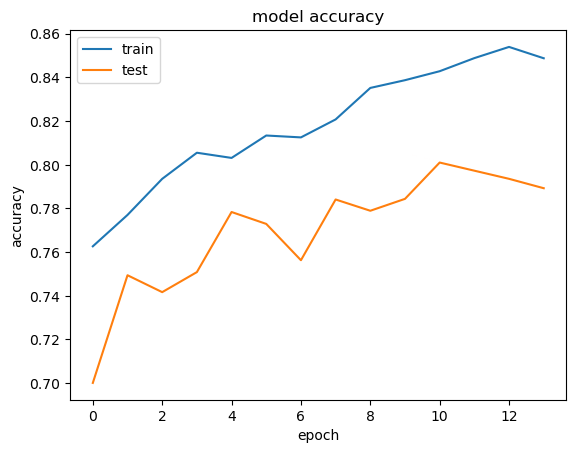

In [38]:
# Plotting the training and validation accuracy over epochs
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


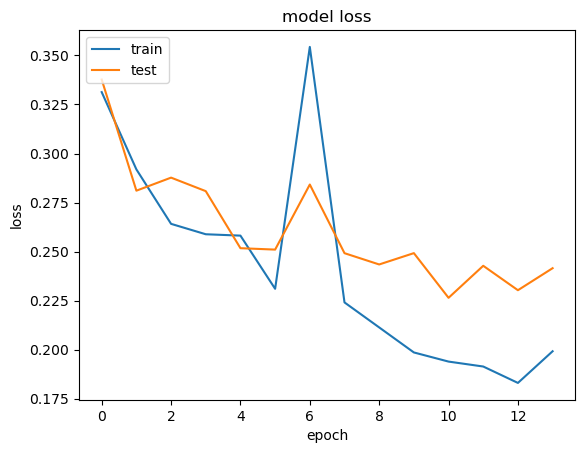

In [39]:
# Plotting the training and validation loss over epochs
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
